# load one of 4 folders

adjust base path based on location

In [1]:
Base_path = "C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/"
Json_paths= []
for scan in range(0,647):
    Json_path = Base_path + "LIDC-IDRI-0"+ str(scan).zfill(3) + "/*/*/" + "segmentation_00"+str(scan).zfill(3)+".json"
    Json_paths.append(Json_path)
    #print(Json_path)
print(Json_paths)

['C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0000/*/*/segmentation_00000.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/*/*/segmentation_00001.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0002/*/*/segmentation_00002.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0003/*/*/segmentation_00003.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0004/*/*/segmentation_00004.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0005/*/*/segmentation_00005.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0006/*/*/segmentation_00006.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0007/*/*/segmentat

# Choose ct scan

In [2]:
import preprocessing

In [3]:
slice_paths, slice_coords = preprocessing.get_slices(Json_path=Json_paths[70])

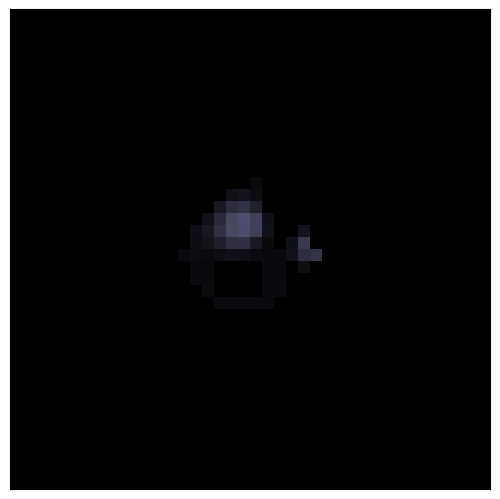

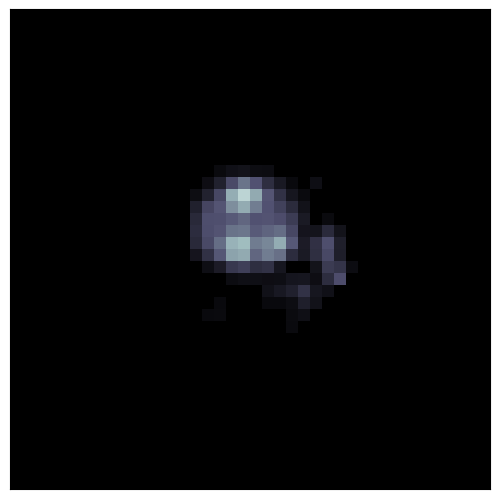

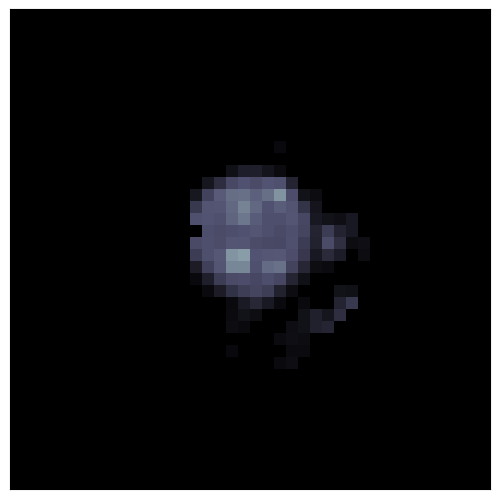

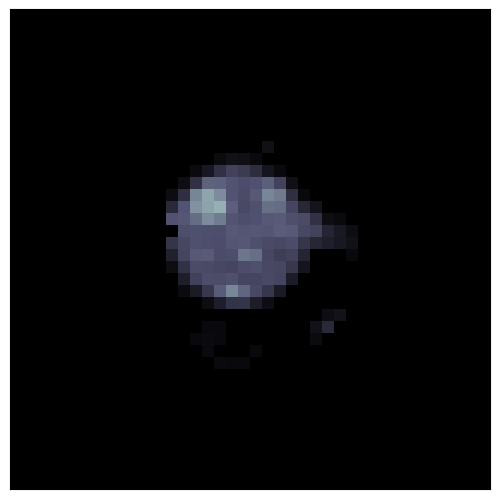

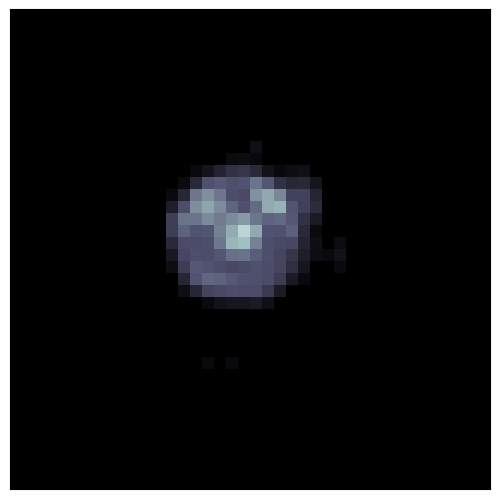

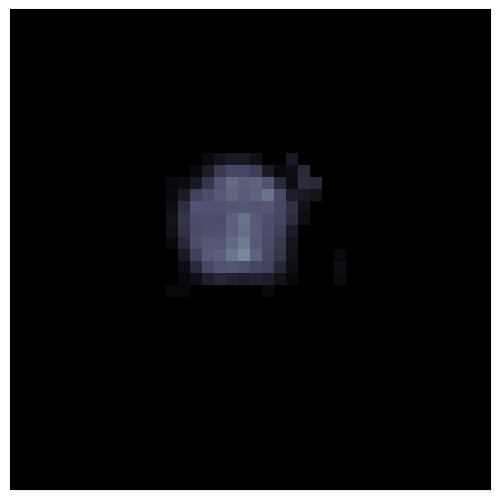

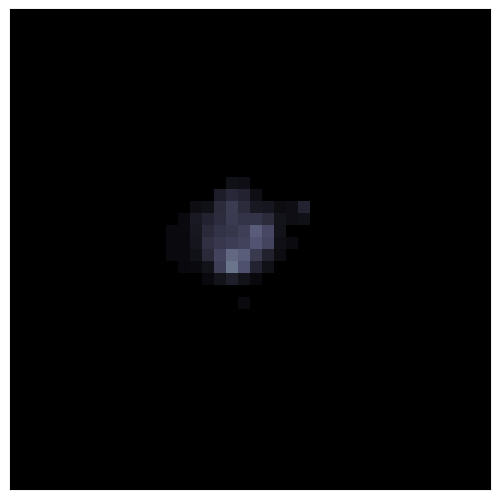

In [ ]:
save_base_path = r"C:\Users\Aidan\Tue\5ARIP10\test" # path used for saved dicom images
preprocessing.preprocess(slice_paths, slice_coords, save_base_path, plot=True, segment=True, save=False, output=False)